# 1. Simulating with Prognostics Models

One of the most basic of functions for models is simulation. Simulation is the process of predicting the evolution of [system's state](https://nasa.github.io/progpy/glossary.html#term-state) with time. Simulation is the foundation of prediction (see 9. Prediction). Unlike full prediction, simulation does not include uncertainty in the state and other product (e.g., [output](https://nasa.github.io/progpy/glossary.html#term-output)) representation.

The first section introduces simulating to a specific time (e.g., 3 seconds), using the `simulate_to` method. The second section introduces the concept of simulating until a threshold is met rather than a defined time, using `simulate_to_threshold`. The third section makes simulation more concrete with the introduction of [future loading](https://nasa.github.io/progpy/glossary.html#term-future-load). The sections following these introduce various advanced features that can be used in simulation.

Note: Before running this example make sure you have ProgPy installed and up to date.

## Basic Simulation to a Time

Let's go through a basic example simulating a model to a specific point in time. In this case we are using the ThrownObject model. ThrownObject is a basic model of an object being thrown up into the air (with resistance) and returning to the ground.

First we import the model from ProgPy's models subpackage (see 3. Included Models) and create a model instance.

In [2]:
from progpy.models import ThrownObject
m = ThrownObject()

Now we simulate this model for three seconds. To do this we use the [`simulate_to`](https://nasa.github.io/progpy/api_ref/prog_models/PrognosticModel.html#prog_models.PrognosticsModel.simulate_to) method.

In [3]:
results = m.simulate_to(3)

It's that simple! We've simulated the model forward three seconds. Let's look in a little more detail at the returned results. 

Simulation results consists of 5 different types of information, described below:
* **times**: the time corresponding to each value.
* **[inputs](https://nasa.github.io/progpy/glossary.html#term-input)**: Control or loading applied to the system being modeled (e.g., current drawn from a battery). Input is frequently denoted by u.
* **[states](https://nasa.github.io/progpy/glossary.html#term-state)**: Internal variables (typically hidden states) used to represent the state of the system. Can be same as inputs or outputs but do not have to be. State is frequently denoted as `x`.
* **[outputs](https://nasa.github.io/progpy/glossary.html#term-output)**: Measured sensor values from a system (e.g., voltage and temperature of a battery). Can be estimated from the system state. Output is frequently denoted by `z`.
* **[event_states](https://nasa.github.io/progpy/glossary.html#term-event-state)**: Progress towards [event](https://nasa.github.io/progpy/glossary.html#term-event) occurring. Defined as a number where an event state of 0 indicates the event has occurred and 1 indicates no progress towards the event (i.e., fully healthy operation for a failure event). For a gradually occurring event (e.g., discharge) the number will progress from 1 to 0 as the event nears. In prognostics, event state is frequently called “State of Health”.

In this case, times are the start and beginning of the simulation ([0, 3]), since we have not yet told the simulator to save intermediate times. The ThrownObject model doesn't have any way of controlling or loading the object, so there are no inputs. The states are position (`x`) and velocity (`v`). This model assumes that you can measure position, so the outputs are just position (`x`). The two events for this model are `falling` (i.e., if the object is falling towards the earth) and `impact` (i.e., the object has impacted the ground). For a real prognostic model, events might be failure modes or warning thresholds.

Now let's inspect the results. First, let's plot the outputs (position)

/Users/cteubert/dev/progpy/src/progpy/exceptions.py:20: UserWarning: Behavior of SimResult.plot() will change with version 1.6. New behavior will match that of a pandas data frame.
  warn(msg, *args, **kwargs)


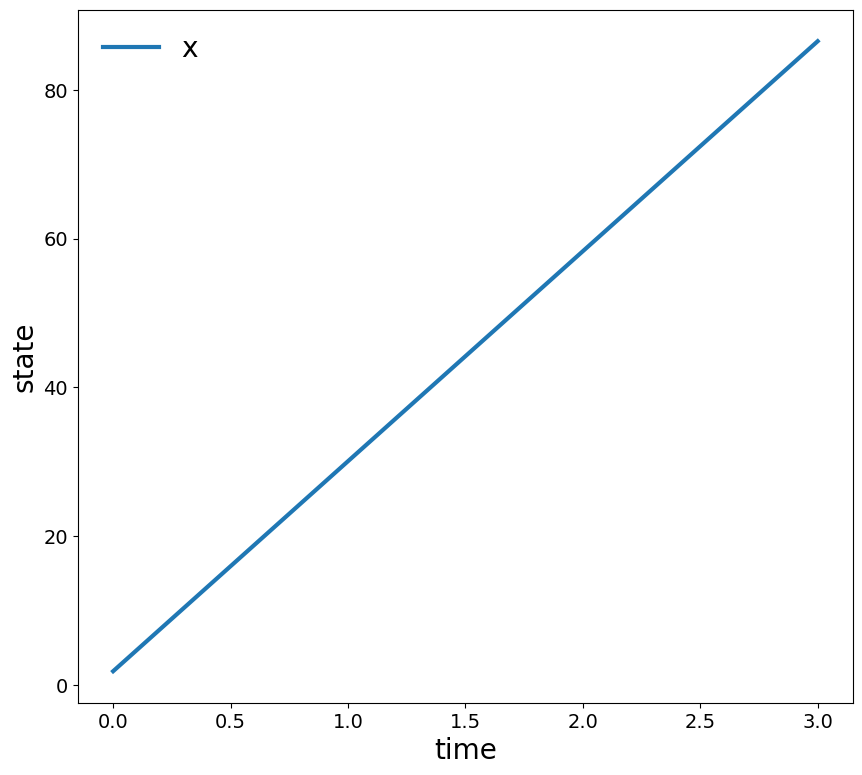

In [4]:
fig = results.outputs.plot()

This is a model of an object thrown in the air, so we generally expect its path to follow a parabola, but what we see above is linear. This is because there are only two points, the start (0s) and the end (3s). To see the parabola we need more points. This is where `save_freq` and `save_pts` come into play. 

`save_freq` is an argument in simulation that specifies a frequency at which you would like to save the results (e.g., 1 seconds), while `save_pts` is used to specify specific times that you would like to save the results (e.g., [1.5, 2.5, 3, 5] seconds).

Now let's repeat the simulation above with a save frequency and plot the results.

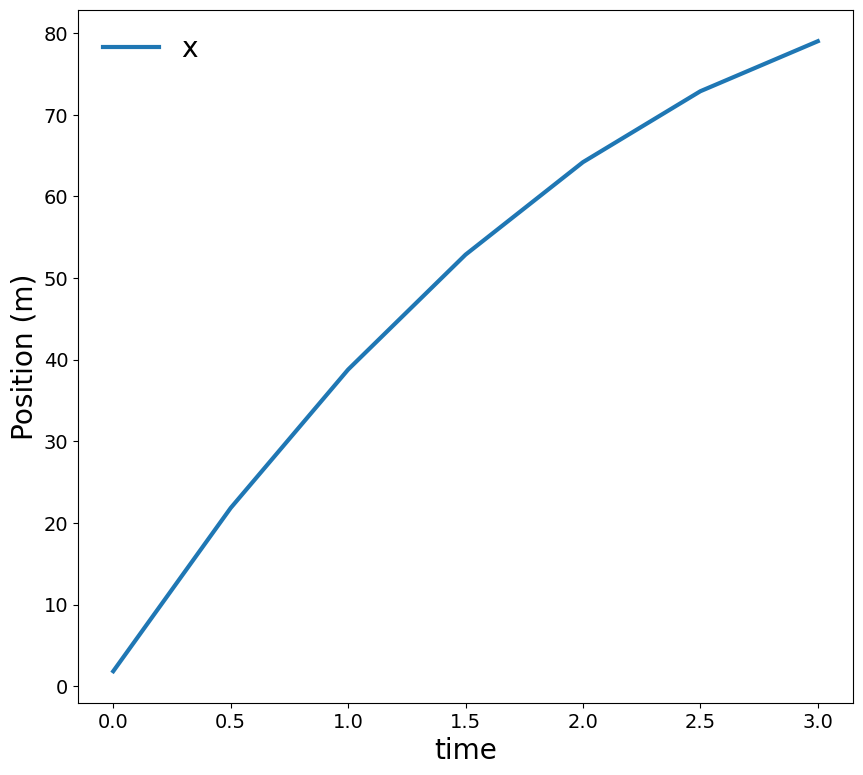

In [5]:
results = m.simulate_to(3, save_freq=0.5)
fig = results.outputs.plot(ylabel='Position (m)')

Now we can see the start of the parabola path we expected. We dont see the full parabola because we stopped simulation at 3 seconds.

If you look at results.times, you can see that the results were saved every 0.5 seconds during simulation

In [6]:
print(results.times)

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]


Next, let's look at the event_states (i.e., `falling` and `impact`).

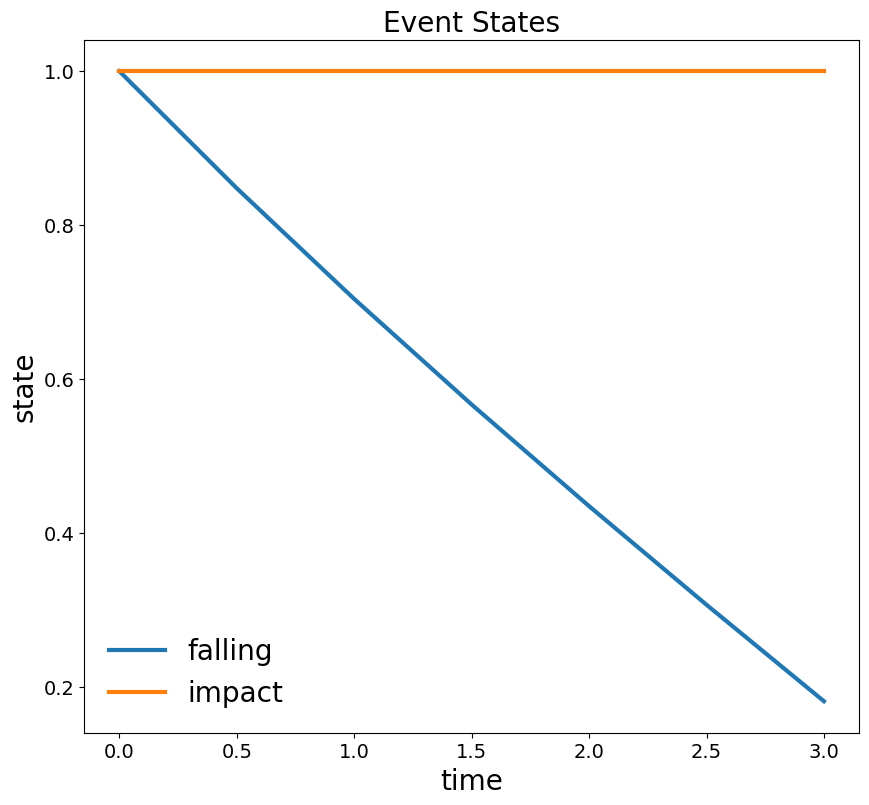

In [7]:
fig = results.event_states.plot()

Here we see that the `falling` event state decreased linerally with time, and was approaching 0. This shows that it was nearly falling when we stopped simulation. The `impact` event state remained at 1, indicating that we had not made any progress towards impact. With this model, `impact` event state only starts decreasing as the object falls. 

Finally, let's take a look at model states. In this case the two states are position (`x`) and velocity (`v`).

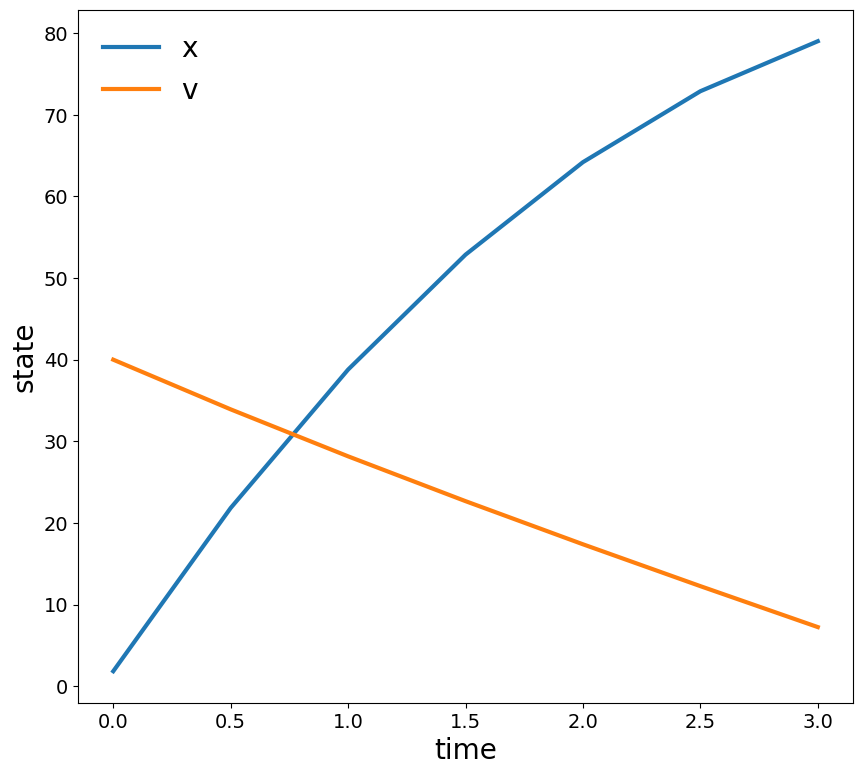

In [11]:
fig = results.states.plot()

Position will match the output exactly and velocity (`v`) decreases nearly linerally with time due to the constant pull of gravity. The slight non-linerality is due to the effects of drag.

This is a basic example of simulating to a set time. This is useful information for inspecting or analyzing the behavior of a model or the degredation of a system. There are many useful features that allow for complex simulation, described in the upcoming sections. 

Note that this is an example problem. In most cases, the system will have inputs, in which case simulation will require future loading (see Future Loading section, below), and simulation will not be until a time, but until a threshold is met. Simulating to a threshold will be described in the next section.

## Simulating to Threshold

* Threshold keys
* horizon
* print
* progress

## Future Loading

## Step Size

## Noise

## Vectorized Simulation

## Configuring Simulation
* t0, x
* integration_method

## Conclusions
...